# Статистический анализ данных сервиса аренды самокатов GoFast.

## Цель:
 проанализировать данные популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, их поездках и проверить некоторые гипотезы чтобы помочь бизнесу вырасти.  

## Описание предоставленных данных

**пользователи** `user_go.csv`   
`user_id` - уникальный идентификатор   
`name`- имя пользователя   
`age` - возраст   
`city` - город   
`subcription_type` - тип подписки  

**поездки** `rides_go.csv`   
`user_id` - уникальный идентификатор   
`distance` -  расстояние, которое пользователь проехал в текущей сессии (в метрах)   
`duration` - продолжительность сессии (в минутах) - время с того момента, как пользователь нажал кнопку НАЧАТЬ ПОЕЗДКУ до момента,как он нажал ЗАВЕРШИТЬ ПОЕЗДКУ   
`date` - дата совершения поездки   

**подписки** `subscriptions_go.csv`  
`subscription_type` - тип подписки  
`minute_price` - стоимость одной минуты поездки по данной подписке  
`start_ride_price` - стоимость начала поездки   
`subscription_fee` - стоимость ежемесячного платежа

### Условия использования сервиса

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.  
 Сервисом можно пользоваться:
- без подписки 
   - абонетская плата - 0 руб;
    - стоимость 1 минуты поездки - 8 руб;
    - стоимость старта(начала поездки) - 50 руб;  
 
- с подпиской ULTRA
    - абонетская плата - 199 руб/мес;
    - стоимость 1 минуты поездки - 6 руб;
    - стоимость старта - 0 руб;

## Загружаем данные

In [290]:
import pandas as pd
import seaborn as sb
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly.express as px


In [291]:

users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')


## Предобработка

Отформатируем названия столбцов

In [292]:
for table in (users, rides, subscriptions):
    format_title_colunms = list(map(lambda x: x.strip(), table.columns))
    table.columns = format_title_colunms

Названия столбцов без пробелов. Отлично.

Посмотрим содержимое датафреймов

In [293]:
def get_info_dataframe(dataframe,
                       transpose=False,
                       count_rows=5
                       ):
    """
    получение основной информации о датафрейме  
    `dataframe` - исследуемый датафрейм   
    `transpose` - перевернуть таблицу на 90°    
    `count_rows` - чило выводимых строк
    """

    # -----------------сбока таблицы с пропусками---------------------
    # число пропусков
    count_missing = dataframe.isna().sum()
    # доля пропусков
    missing_percent = count_missing/len(dataframe)*100

    # сборка
    df = pd.DataFrame(data={'missing_percent': missing_percent,
                            'count_missing': count_missing
                            })
    # цветной бар в столбце с долей пропусков и добапвляем знак %
    table = (df
             .style
             .bar(
                 subset="missing_percent",
                 vmax=100,
                 color='red'
             )
             .format(
                 subset="missing_percent",
                 formatter="{:.2f} %")
             )

    # --------------------------------------

    # сводная информация
    print(dataframe.info())

    # часть таблицы
    if transpose == True:
        display(dataframe.head(count_rows).T)
    else:
        display(dataframe.head(count_rows))

    # число дубликатов
    print(
        f'\nявных дубликатов: {dataframe.duplicated().sum()}\n{". "*10}'.upper())

    # число пропусков
    print(f'\nпропуски'.upper())
    display(table)

    print('----'*20)

In [294]:
for table in (users, rides, subscriptions):
    get_info_dataframe(dataframe=table)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



ЯВНЫХ ДУБЛИКАТОВ: 31
. . . . . . . . . . 

ПРОПУСКИ


,missing_percent,count_missing
user_id,0.00 %,0
name,0.00 %,0
age,0.00 %,0
city,0.00 %,0
subscription_type,0.00 %,0


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



ЯВНЫХ ДУБЛИКАТОВ: 0
. . . . . . . . . . 

ПРОПУСКИ


,missing_percent,count_missing
user_id,0.00 %,0
distance,0.00 %,0
duration,0.00 %,0
date,0.00 %,0


--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



ЯВНЫХ ДУБЛИКАТОВ: 0
. . . . . . . . . . 

ПРОПУСКИ


,missing_percent,count_missing
subscription_type,0.00 %,0
minute_price,0.00 %,0
start_ride_price,0.00 %,0
subscription_fee,0.00 %,0


--------------------------------------------------------------------------------


Дубликаты есть в `users`. Исправим. и проверим

In [295]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

Приведем столбец `date` к типу данных `datetime`

In [296]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Всё нормально

Создадим столбец `month` с номером месяца на основе столбца `date` в таблице rides

In [297]:
rides['month'] = pd.DatetimeIndex(rides['date']).month
rides[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


Код работает, продолжаем

Узнаем период, за который взяты данные, и сколько месяцев включают

In [298]:
print(
    f"Данные взяты с {rides['date'].dt.date.min()} по {rides['date'].dt.date.max()}")

Данные взяты с 2021-01-01 по 2021-12-30


Все месяцы 2021 года включены в данные

Краткий вывод:   
В таблице `users` были обнаружены дубликаты. Исходя их набора данных дубликатом могут быть строки с одинаковыми `user_id` (при одинаковых данных о пользователе и типе подписке). Значит причина дубликатов сторона техническая.  
Пометим для баг-репорта.

## Исследовательский анализ данных


###  Изучим частоту встречаемости городов

In [299]:
city = users['city'].value_counts().reset_index()
city.columns = ['city', 'count']
city

,city,count
0,Пятигорск,219
1,Екатеринбург,204
2,Ростов-на-Дону,198
3,Краснодар,193
4,Сочи,189
5,Омск,183
6,Тюмень,180
7,Москва,168


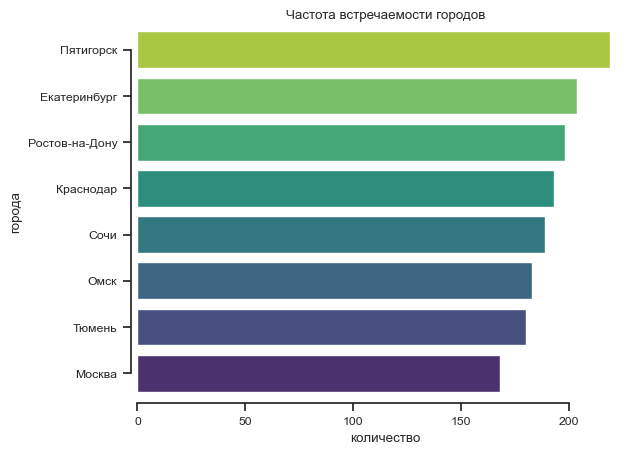

In [300]:
sb.set_theme(style="ticks", font_scale=0.8)
sb.barplot(data=city, y='city', x='count', palette='viridis_r')
sb.despine(offset=5, trim=True)
plt.title("Частота встречаемости городов")
plt.xlabel("количество")
plt.ylabel("города")

Чаще встречается в таблице город Пятигорск, реже - Москва, наверное сервисом GoFast чаще пользуются в Пятигорске.

### Узнаем соотношение пользователей с подпиской и без

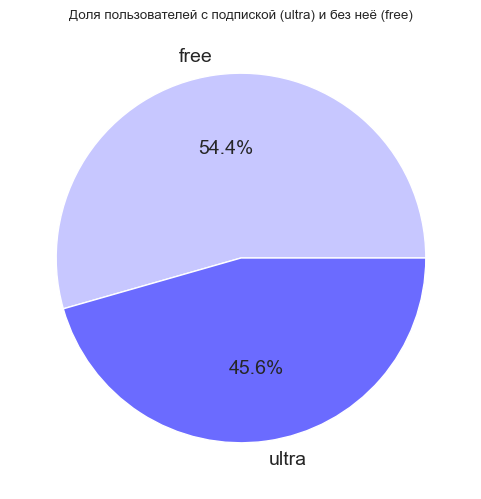

In [301]:
users_subscription_type = users.groupby('subscription_type')['user_id'].count()
users_subscription_type.plot(kind='pie',
                             autopct='%1.1f%%',
                             figsize=(6, 6),
                             textprops={'fontsize':14},
                             colors=['#C7C7FF', '#6B6BFF'])
plt.ylabel(None)

plt.title('Доля пользователей с подпиской (ultra) и без неё (free)');

Получается чуть больше пользователей без подписки

### Изучим возраст пользователей

In [302]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Пользуются самокатами пользователи от 12 до 43 лет.

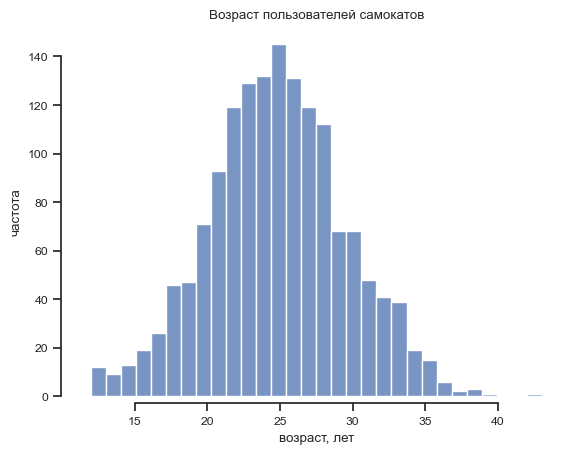

In [303]:

sb.histplot(data=users['age']);
sb.despine(offset=5, trim=True)
plt.xlabel('возраст, лет');
plt.ylabel('частота');
plt.title('Возраст пользователей самокатов');

Узнаем, люди каких возрастов берут в аренду самокаты чаще всего -   
напишем функцию возвращающую границы интервала в котоом находятся часто встречаемые значения, то есть: границы = среднее +- стандартное отклонение

In [304]:
def get_bounds_1(arg, type_mean='mean'):
    if type_mean == 'median':
        m = arg.median()
    else:
        m = arg.mean()

    return round(m-arg.std()), round(m+arg.std())

Считаем и выводим на экран

In [305]:

bound_age_min, bound_age_max =get_bounds_1(users['age'])
print(f'Часто арендуют скутеры пользователи от {bound_age_min} до {bound_age_max} лет')


Часто арендуют скутеры пользователи от 20 до 29 лет


### Изучим расстояние которое пользователь преодолел за одну поездку

In [306]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

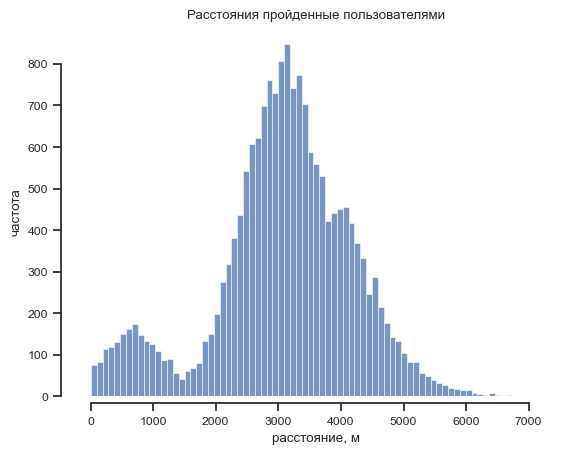

In [307]:
sb.histplot(rides['distance']);
sb.despine(offset=5, trim=True);
plt.xlabel('расстояние, м');
plt.ylabel('частота');
plt.title('Расстояния пройденные пользователями');

На графике 2 "колокола" - один с 0 до 1500 м, второй - 1500 -7211 м.  

по второму колоколу можно сказать что пользователи чаще преоделевают расстояния с 2500 м до 4500 м.


In [308]:
def get_bounds(arg):
    # квартиль 1ый
    q1 = arg.quantile(0.25)
    # квартиль 3ий
    q3 = arg.quantile(0.75)
    # межквартильный размах IQR
    iqr = q3 - q1

    # крайние усы 
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    return lower_bound, upper_bound

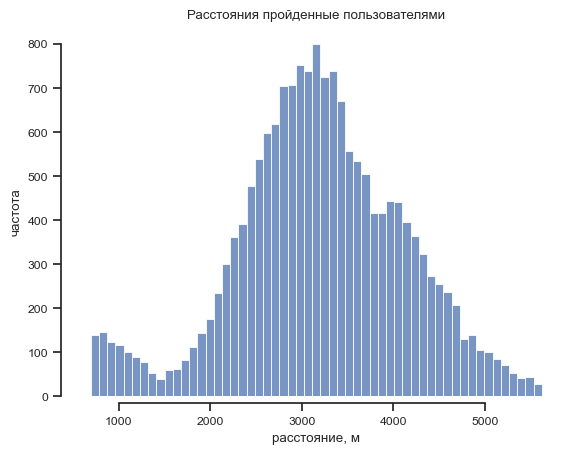

In [309]:
lower_bound, upper_bound = get_bounds(rides['distance'])

rides_distance = (rides['distance']
                  .loc[
    (rides['distance'] > lower_bound)
    &
    (rides['distance'] < upper_bound)
]
)

sb.histplot(rides_distance)
sb.despine(offset=5, trim=True)
plt.xlabel('расстояние, м')
plt.ylabel('частота')
plt.title('Расстояния пройденные пользователями')

In [310]:
low_bound, up_bound = get_bounds_1(rides['distance'], type_mean='median')

print(
    f'В основном пользователи преодолевают расстояния от {low_bound} до {up_bound} метров')

В основном пользователи преодолевают расстояния от 2017 до 4250 метров


### Изучим продолжительность поездок

In [311]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Ехать 40 минут на самокате можно, а вот 30 сек наврядли. Посмотрим подробнее

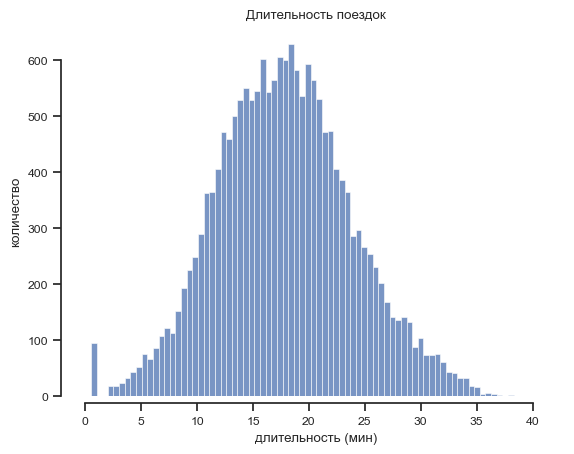

In [312]:
sb.histplot(rides['duration'], bins=80);
sb.despine(offset=5, trim=True);
plt.xlabel('длительность (мин)');
plt.ylabel('количество');
plt.title('Длительность поездок');

In [313]:
rides['duration'].loc[rides['duration'] < 2].value_counts()

0.5    95
Name: duration, dtype: int64

95 поездок завершены за 30 сек. Совпадение? нет не думаю. Аномалия с технической стороны. Пометим для баг-репорта. 

Найдем среднее время затраченное на поездку и основную длительность поездок.

In [314]:
duration_bound_min, duration_bound_max = get_bounds_1(rides['duration'])


print(f'Cредняя длительность поездки: ',
      round(rides['duration'].mean()), 'мин')


print(
    f'В основном поездки длятся от {duration_bound_min} до {duration_bound_max} мин')

Cредняя длительность поездки:  18 мин
В основном поездки длятся от 12 до 24 мин


### Объединение данных

Обьединим данные о пользователях, поездках и подписках в один датафрейм

In [315]:
total_data = users.merge(rides,
                         on='user_id',
                         how='inner'
                         )

total_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [316]:
total_data = total_data.merge(subscriptions,
                              on='subscription_type',
                              how='inner'
                              )


total_data.head().T

,0,1,2,3,4
user_id,1,1,1,1,1
name,Кира,Кира,Кира,Кира,Кира
age,22,22,22,22,22
city,Тюмень,Тюмень,Тюмень,Тюмень,Тюмень
subscription_type,ultra,ultra,ultra,ultra,ultra
distance,4409.91914,2617.592153,754.159807,2694.783254,4028.687306
duration,25.599769,15.816871,6.232113,18.511,26.265803
date,2021-01-01 00:00:00,2021-01-18 00:00:00,2021-04-20 00:00:00,2021-08-11 00:00:00,2021-08-28 00:00:00
month,1,1,4,8,8
minute_price,6,6,6,6,6


Проверим количество строк таблицы до и после обьединения. Так как таблица `rides` дополняется данными из двух других таблиц (добавляются столбцы), то сравнивать будем ее с таблицей `total_data`

In [317]:
print('Строк в таблице rides:', len(rides))
print('Строк в таблице total_data:', len(total_data))

Строк в таблице rides: 18068
Строк в таблице total_data: 18068


Количество строк до и после слияния одинаково. Слияние прошло успешно

Создадим 2 датафрейма - в одном пользователи с подпиской, в другом - без.

In [318]:
users_free = total_data.query('subscription_type=="free"')
users_ultra = total_data.query('subscription_type=="ultra"')

### Построение графиков длительности сессий и расстояний для каждой категории пользователей.

#### Дистанция пройденная пользователями с подпиской и без нее

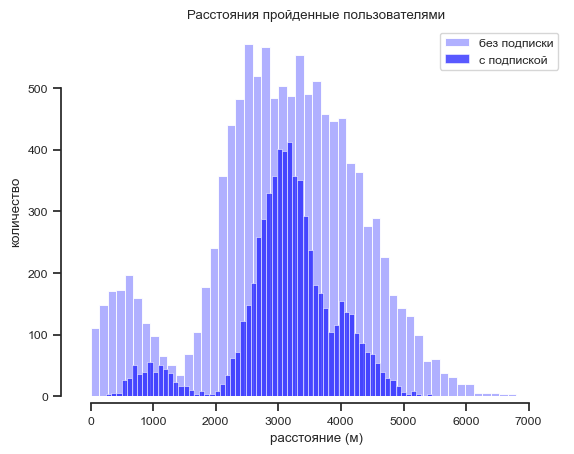

In [319]:
sb.histplot(users_free['distance'], color='#9696FF');
sb.histplot(users_ultra['distance'], color='#2121FF');
sb.despine(offset=5, trim=True)
plt.legend(['без подписки', 'с подпиской']);
plt.title('Расстояния пройденные пользователями');
plt.xlabel('расстояние (м)');
plt.ylabel('количество');

Пользователи с подпиской преодолевают расстояния (см. вторые пики) в основном 2.5-4 км , а без нее - 2-4.5 км 

Загадкой по-прежнему остаются первые пики. 

#### Длительность поездок пользователей с подпиской и без нее

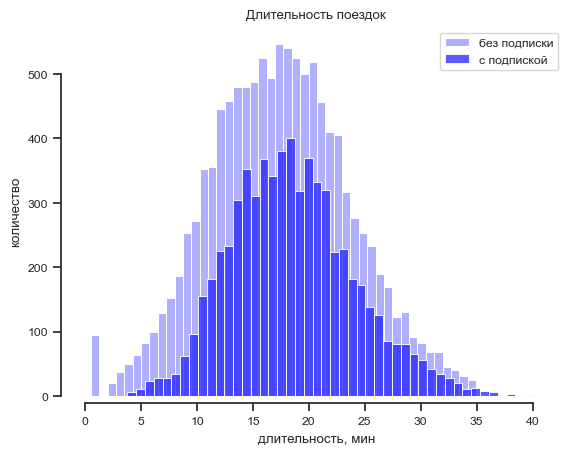

In [320]:
sb.histplot(users_free['duration'], color='#9696FF');
sb.histplot(users_ultra['duration'], color='#2121FF');
sb.despine(offset=5, trim=True);
plt.legend(['без подписки','с подпиской']);
plt.title('Длительность поездок');
plt.xlabel('длительность, мин');
plt.ylabel('количество');

Распределения напоминают друг друга очертаниями - похоже, что приезжают в одни и те же места независимо от подписки.  

In [321]:

for value, name in zip([users_free['duration'],
                        users_ultra['duration']
                        ],
                       ['без подписки',
                        'с подпиской']):
    duration_bound_min, duration_bound_max = (get_bounds_1(value,
                                                           type_mean='median'))
    print(
        f'В основном поездки пользователей {name} длятся от {duration_bound_min} до {duration_bound_max} мин')

В основном поездки пользователей без подписки длятся от 11 до 24 мин
В основном поездки пользователей с подпиской длятся от 13 до 24 мин


### Подсчет выручки


Округлим длительности поездок принудительно до целого

In [322]:
total_data['duration'] = np.ceil(total_data['duration'])


Создадим сводную таблицу, в ключающую в себя, по месяцам, длительность поездок, пройденное расстояние, количество поездок

In [323]:
aggregate_data = total_data.pivot_table(index=['user_id', 'month'],
                                        values=['distance', 'duration',
                                                'start_ride_price',
                                                'minute_price',
                                                'subscription_fee',
                                                'subscription_type'],
                                        aggfunc={'distance': 'sum',
                                                 'duration': 'sum',
                                                 'start_ride_price': 'first',
                                                 'minute_price': 'first',
                                                 'subscription_fee': 'first',
                                                 'subscription_type': 'first'})


# проверим
aggregate_data.head(10)

distance  duration  minute_price  start_ride_price  \
user_id month                                                           
1       1       7027.511294      42.0             6                 0   
        4        754.159807       7.0             6                 0   
        8       6723.470560      46.0             6                 0   
        10      5809.911100      32.0             6                 0   
        11      7003.499363      56.0             6                 0   
        12      6751.629942      28.0             6                 0   
2       3      10187.723006      63.0             6                 0   
        4       6164.381824      40.0             6                 0   
        6       3255.338202      14.0             6                 0   
        7       6780.722964      48.0             6                 0   

               subscription_fee subscription_type  
user_id month                                      
1       1                   199             ultra  
        4                   199             ultra  
        8                   199             ultra  
        10                  199             ultra  
        11                  199             ultra  
        12                  199             ultra  
2       3                   199             ultra  
        4                   199             ultra  
        6                   199             ultra  
        7                   199             ultra

Добавим столбец с количесвсвом поездок за месяц и переместим столбец в начало для удобства чтения таблицы

In [324]:
aggregate_data['count_rides'] = total_data.pivot_table(index=['user_id', 'month'],
                                                       values='distance',
                                                       aggfunc='count')
# переставляем новый столбец в начало
aggregate_data.insert(0, 'count_rides', aggregate_data.pop('count_rides'))
aggregate_data.head()

count_rides     distance  duration  minute_price  \
user_id month                                                     
1       1                2  7027.511294      42.0             6   
        4                1   754.159807       7.0             6   
        8                2  6723.470560      46.0             6   
        10               2  5809.911100      32.0             6   
        11               3  7003.499363      56.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra

Переименуем столбцы

In [325]:
aggregate_data = aggregate_data.rename(columns={'distance': 'total_distance',
                                                'duration': 'total_duration'})

aggregate_data.head()

count_rides  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294            42.0             6   
        4                1      754.159807             7.0             6   
        8                2     6723.470560            46.0             6   
        10               2     5809.911100            32.0             6   
        11               3     7003.499363            56.0             6   

               start_ride_price  subscription_fee subscription_type  
user_id month                                                        
1       1                     0               199             ultra  
        4                     0               199             ultra  
        8                     0               199             ultra  
        10                    0               199             ultra  
        11                    0               199             ultra

Формула расчета стоимости   
стоимость_старта_поездки * количество_поездок + стоимость_1_мин * общая_продолжитиельность_поездок + стоимость_подписки 

In [326]:
aggregate_data['revenue'] = (aggregate_data['start_ride_price'] * aggregate_data['count_rides'] +
                             aggregate_data['minute_price'] * aggregate_data['total_duration'] +
                             aggregate_data['subscription_fee'])


aggregate_data.head()

count_rides  total_distance  total_duration  minute_price  \
user_id month                                                              
1       1                2     7027.511294            42.0             6   
        4                1      754.159807             7.0             6   
        8                2     6723.470560            46.0             6   
        10               2     5809.911100            32.0             6   
        11               3     7003.499363            56.0             6   

               start_ride_price  subscription_fee subscription_type  revenue  
user_id month                                                                 
1       1                     0               199             ultra    451.0  
        4                     0               199             ultra    241.0  
        8                     0               199             ultra    475.0  
        10                    0               199             ultra    391.0  
        11                    0               199             ultra    535.0

### Проверка гипотез

Нулевая гипотеза -   пользователи с подпиской тратят  времени на поездки столько же сколько пользователи без подписки.  
Альтернативная гипотеза -  пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.

In [327]:
hipotesys_1={'H_0':'пользователи с подпиской тратят  времени на поездки столько же сколько пользователи без подписки',
           'H_1':'пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.'}

In [328]:
alpha = 0.05
print('Средняя подолжительность поездок пользователей')
print(f'с подпиской: {round(users_ultra["duration"].mean(),3)} мин')
print(f'без подписки: {round(users_free["duration"].mean(),3)} мин\n')

# применяем двухвыборочный т-тест для независмых выборок с правосторонней альт. гипотезой
results = (st.ttest_ind(users_ultra['duration'],
                        users_free['duration'],
                        alternative='greater'))

print('p-value:', results.pvalue)


if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_1.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу о {hipotesys_1.get("H_0")}')

Средняя подолжительность поездок пользователей
с подпиской: 18.542 мин
без подписки: 17.391 мин

p-value: 1.2804098316645613e-34
Результаты в пользу альт. гипотезы - пользователи с подпиской тратят БОЛЬШЕ времени на поездки, чем пользователи без подписки.


Вывод: выходит, что пользователи с подпиской тратят на поездки больше времени, чем пользователи без нее

Нулевая гипотеза -среднее расстояние, пройденное пользователями с подпиской, равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката)  
Альтернативная гипотеза - среднее расстояние, пройденное пользователями с подпиской, БОЛЬШЕ 3130 метров


In [329]:
hipotesys_2={'H_0':'среднее расстояние, пройденное пользователями с подпиской,\n равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката) ',
           'H_1':'среднее расстояние, пройденное пользователями с подпиской, БОЛЬШЕ 3130 метров'}

In [330]:
optimal_value = 3130
alpha = 0.05

# применяем одновыборочный t-test / проверяется правосторонняя альт. гипотеза
results = (st.ttest_1samp(users_ultra['distance'],
                          optimal_value,
                          alternative='greater'))

print('p-value:', '{:.3}'.format(results.pvalue))

if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_2.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу - {hipotesys_2.get("H_0")}')

p-value: 0.92
Не отвергаем нулевую гипотезу - среднее расстояние, пройденное пользователями с подпиской,
 равно значению 3130 метров(оптимальное расстояние с точки зрения износа самоката) 


Вывод: пользователи с подпиской проходят расстояние равное 3130 метров, а значит  самокаты не будут изнашиваться быстрее.

Нулевая гипотеза  - помесячная выручка от пользователей с подпиской по месяцам равна выручке пользователей без подписки.  
Альтернативная гипотеза - помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ, чем выручка от пользователей без подписки.

In [331]:
hipotesys_3={'H_0':'помесячная выручка от пользователей с подпиской по месяцам равна выручке пользователей без подписки.',
           'H_1':'помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ,\n чем выручка от пользователей без подписки'}

In [332]:
alpha = 0.05

# выручка пользователей с подпиской
revenue_user_ultra = aggregate_data['revenue'].loc[aggregate_data['subscription_type'] == 'ultra']

# выручка пользователей без подписки
revenue_user_free = aggregate_data['revenue'].loc[aggregate_data['subscription_type'] == 'free']

# применяем двухвыборочный t-test для независимых выборок с правостороннней альтернативной гипотезой
results = (st.ttest_ind(revenue_user_ultra,
                        revenue_user_free,
                        alternative='greater')
           )

print('p-value:', '{:.3}'.format(results.pvalue))

if results.pvalue < alpha:
    print(f'Результаты в пользу альт. гипотезы - {hipotesys_3.get("H_1")}')
else:
    print(f'Не отвергаем нулевую гипотезу - {hipotesys_3.get("H_0")}')

p-value: 1.89e-31
Результаты в пользу альт. гипотезы - помесячная выручка от пользователей с подпиской по месяцам БОЛЬШЕ,
 чем выручка от пользователей без подписки


Вывод: значит помесячная выручка пользователей с подпиской выше чем помесячная выручка пользователей без подписки

## Итоговый вывод  

Устранив дубликаты, приведя формат даты к необходимому, ислледовали данные, взятые за период с 01-01-2021 по 30-12-2021 гг о пользователях севиса аренды самокатов GoFast, а также, обьединив 3 таблицы о пользователях, поездках, подписках рассчитали выручку помесячно для каждого пользователя и проверили следующие гипотезы: 
1. тратят ли пользователи с подпиской больше времени на поездки
2. проезжают ли пользователи с подпиской больше оптимального расстояния с точки зрения износа  самоката
3. приносят ли пользователи с подпиской больше выручки чем пользователи без нее.

Обнаружено следующее:  
Больше всего пользователей обнаружено в г.Пятигорске, меньше - в Москве;  
услугой сервиса пользуются граждане от 12 до 43 лет;   
но в основном арендуют пользователи от 20 до 29 лет;
пользователей без подписки больше пользователей с подпиской (54.4% против 45.4% соответсвенно);
пользователи без подписки проезжают расстояния от 2 до 4.5 км,  
с подпиской - 2.5 - 4 км, а в целом все пользователи проезжают расстояния от 2 - 4.5 км;
длительность поездок пользователей обоех групп почти одинакова : с подпиской - 11-24 мин, без подписки - 13-24 мин.  

Проверив гипотезы, приходим к выводам, что  
в отличии от пользователей без подписки, пользователи с подпиской тратят больше времени на поездки,но проезжают расстояния в основном раное опттимальному расстояния с точки  зрения износа самоката, то есть 3130 метров, и приносят больше выручки , а значит, являются более выгодными для компании.

Рекомендации.
1. Уделить больше внимания техническому обслуживанию самокатов.
2. Уделить внимание расчетам времени поездок и расстояния. 


Баг-репорт   
1. обнаружены строки-дубликаты в таблице с пользователями (файл users_go.csv). Причиной может быть техническая сторона.  
2. обнаружены проблемы с расчетом времени поездок (95 поездок завершились ровно за 30 сек.) и расстояний (некоторые дистанции исчисляются несколькими метрами или вовсе меньше метра )
